In [1]:
import sys
import numpy as np

In [2]:
def preprocess(txt):
    txt = txt.lower().replace('.', ' .')
    word2id, id2word = dict(), dict()
    words = txt.split()
    for word in words:
        if word not in word2id:
            new_id = len(word2id)
            word2id[word] = new_id
            id2word[new_id] = word
    
    corpus = np.array([word2id[w] for w in words])
    return corpus, word2id, id2word

In [3]:
text = 'You say goodbye and I say hello.'

corpus, word2id, id2word = preprocess(text)

corpus

array([0, 1, 2, 3, 4, 1, 5, 6])

In [5]:
id2word

{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}

In [6]:
# 동시발생 행렬
C = np.array([
    [0, 1, 0, 0, 0, 0, 0],
    [1, 0, 1, 0, 1, 1, 0],
    [0, 1, 0, 1, 0, 0, 0],
    [0, 0, 1, 0, 1, 0, 0],
    [0, 1, 0, 1, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 1],
    [0, 0, 0, 0, 0, 1, 0],
], dtype=np.int32)

C

array([[0, 1, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 1, 0],
       [0, 1, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 1, 0, 0],
       [0, 1, 0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1, 0]], dtype=int32)

In [7]:
print(f'id가 0인 단어의 벡터 표현: {C[0]}')

id가 0인 단어의 벡터 표현: [0 1 0 0 0 0 0]


In [8]:
print(f'goodbye의 벡터 표현: {word2id['goodbye']}')

goodbye의 벡터 표현: 2


In [10]:
def create_co_matrix(corpus, vocab_size, window_size=1):
    corpus_size = len(corpus)
    co_matrix = np.zeros((vocab_size, vocab_size), dtype=np.int32) # 0으로 초기화
    
    # 말뭉치의 모든 단어 각각에 대해 윈도우에 포함된 주변 단어를 세어감
    for idx, word_id in enumerate(corpus):
        for i in range(1, window_size + 1):
            left_idx, right_idx = idx - i, idx + i
            
            if left_idx >= 0:
                left_word_id = corpus[left_idx]
                co_matrix[word_id, left_word_id] += 1
            
            if right_idx < corpus_size:
                right_word_id = corpus[right_idx]
                co_matrix[word_id, right_word_id] += 1
        
    return co_matrix

In [12]:
# 벡터간 유사도 - 코사인 유사도
"eps를 더하는 이유: 인수로 원소가 모두 0인 벡터가 들어오면 divide by zero 오류 발생 방지"
def cos_similarity(x, y, eps=1e-8):
    nx = x / np.sqrt(np.sum(x ** 2) + eps)
    ny = y / np.sqrt(np.sum(y ** 2) + eps)
    return np.dot(nx, ny) # -1 ~ 1 사이의 값

In [13]:
vocab_size = len(word2id)
C = create_co_matrix(corpus, vocab_size)

c0, c1 = C[word2id['you']], C[word2id['i']]

print(cos_similarity(c0, c1))

0.7071067758832467


In [14]:
# 검색어와 비슷한 단어를 유사도 순으로 출력하는 함수
def most_similar(query, word2id, id2word, word_matrix, top=5):
    if query not in word2id: # 검색어를 꺼냄
        return
    
    query_id = word2id[query]
    query_vector = word_matrix[query_id]
    
    # 코사인 유사도 계산
    vocab_size = len(id2word)
    similarity = np.zeros(vocab_size)
    for i in range(vocab_size):
        similarity[i] = cos_similarity(word_matrix[i], query_vector)
    
    # 코사인 유사도를 기준으로 값이 높은 순서대로 top개 출력
    count = 0
    for i in (-1 * similarity).argsort():
        if id2word[i] == query:
            continue
        print(id2word[i], similarity[i])
        count += 1
        if count >= top:
            return

In [15]:
C = create_co_matrix(corpus, vocab_size)
most_similar('you', word2id, id2word, C)

goodbye 0.7071067758832467
i 0.7071067758832467
hello 0.7071067758832467
say 0.0
and 0.0


### PMI (Pointwise Mutual Information)
> 특정 단어 쌍이 독립적으로 나타나는 것보다 함께 나타날 확률이 얼마나 높은지를 측정하는 지표
> 
> PMI 값이 클수록 두 단어가 서로 강한 연관성을 가지며, 값이 작으면 연관성이 낮다

$$
\[
PMI(x,y) = \log_2 \frac{P(x,y)}{P(x)P(y)}
= \log_2 \frac{\frac{C(x,y)}{N}}{\frac{C(x)}{N} \frac{C(y)}{N}}
= \log_2 \frac{C(x,y) \cdot N}{C(x)C(y)}
\]
$$

- P(w, c)  : 단어  w 와 문맥 단어  c 가 동시에 등장할 확률
- P(w)  : 단어  w 가 등장할 확률
- P(c)  : 문맥 단어  c 가 등장할 확률

PMI 특징
	•	PMI 값이 0보다 크면 단어들이 기대보다 자주 등장함을 의미
	•	PMI 값이 0이면 단어들이 서로 독립적임을 의미
	•	PMI 값이 0보다 작으면 단어들이 기대보다 덜 등장함을 의미
	
### PPMI (Positive PPMI)
> 음수 값을 제거해 음의 연관성을 고려하지 않음 (음수여도 0으로 처리됨)
> 희소한 데이터에서도 안정적 사용가능

$$

PPMI(w, c) = \max(PMI(w, c), 0)

$$

In [19]:
from IPython.display import clear_output
from time import sleep

def ppmi(C, verbose=False, eps=1e-8):
    M = np.zeros_like(C, dtype=np.float32)
    N = np.sum(C)
    S = np.sum(C, axis=0)
    total, cnt = C.shape[0] * C.shape[1], 0
    
    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            pmi = np.log2(C[i, j] * N / (S[j] * S[i]) + eps)
            M[i, j] = max(0, pmi)
            
            if verbose:
                cnt += 1
                if cnt % (total // 100 + 1) == 0:
                    clear_output(wait=True)
                    print('%.1f%% 완료 ' % (100 * cnt / total))
                    sleep(0.4)
    
    return M

In [21]:
W = ppmi(C)

np.set_printoptions(precision=3) # 유효자릿수 3개
print(C)

[[0 1 0 0 0 0 0]
 [1 0 1 0 1 1 0]
 [0 1 0 1 0 0 0]
 [0 0 1 0 1 0 0]
 [0 1 0 1 0 0 0]
 [0 1 0 0 0 0 1]
 [0 0 0 0 0 1 0]]


In [23]:
print(W)

[[0.    1.807 0.    0.    0.    0.    0.   ]
 [1.807 0.    0.807 0.    0.807 0.807 0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.    1.807 0.    1.807 0.    0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.807 0.    0.    0.    0.    2.807]
 [0.    0.    0.    0.    0.    2.807 0.   ]]


### 특잇값분해(SVD)와 차원축소

In [24]:
import matplotlib.pyplot as plt

U, S, V = np.linalg.svd(W)

In [25]:
"단어 ID가 0인 단어 벡터"
print(C[0]) # 동시발생 행렬
print(W[0]) # PPMI 행렬
print(U[0]) # SVD

[0 1 0 0 0 0 0]
[0.    1.807 0.    0.    0.    0.    0.   ]
[ 3.409e-01  0.000e+00  1.205e-01 -3.608e-16 -1.110e-16  9.323e-01
  1.626e-16]


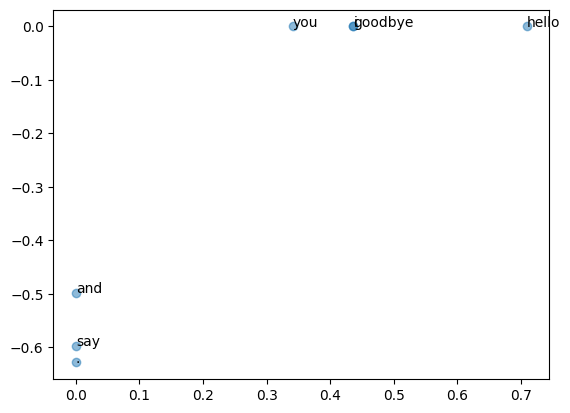

In [26]:
for word, word_id in word2id.items():
    plt.annotate(word, (U[word_id, 0], U[word_id, 1]))

plt.scatter(U[:, 0], U[:, 1], alpha=0.5)
plt.show()

### dataset - ptb 사용해보기

In [38]:
from dataset import ptb

corpus, word2id, id2word = ptb.load_data('train')

len(corpus)

929589

In [39]:
id2word[0]

'aer'

In [41]:
word2id['aer']

0

In [43]:
window_size = 2
wordvec_size = 100
querys = ['you', 'year', 'car', 'toyota']

In [45]:
corpus, word2id, id2word = ptb.load_data('train')
vocab_size = len(word2id)
C = create_co_matrix(corpus, vocab_size, window_size)
W = ppmi(C, verbose=True)

"""
고속 SVD - sklearn 모듈 사용
느린 SVD - np.linalg.svd
"""
try:
    from sklearn.utils.extmath import randomized_svd
    # truncated SVD: 특이값이 큰 것만 계산하여 빠르다
    U, S, V = randomized_svd(
        W, 
        n_components=wordvec_size,
        n_iter=5,
        random_state=None
    )
except ImportError:
    U, S, V = np.linalg.svd(W)

word_vecs = U[:, :wordvec_size]
for query in querys:
    print(f'query: {query}')
    most_similar(query, word2id, id2word, word_vecs, top=5)

1.0% 완료 
2.0% 완료 
3.0% 완료 
4.0% 완료 
5.0% 완료 
6.0% 완료 
7.0% 완료 
8.0% 완료 
9.0% 완료 
10.0% 완료 
11.0% 완료 
12.0% 완료 
13.0% 완료 
14.0% 완료 
15.0% 완료 
16.0% 완료 
17.0% 완료 
18.0% 완료 
19.0% 완료 
20.0% 완료 
21.0% 완료 
22.0% 완료 
23.0% 완료 
24.0% 완료 
25.0% 완료 
26.0% 완료 
27.0% 완료 
28.0% 완료 
29.0% 완료 
30.0% 완료 
31.0% 완료 
32.0% 완료 
33.0% 완료 
34.0% 완료 
35.0% 완료 
36.0% 완료 
37.0% 완료 
38.0% 완료 
39.0% 완료 
40.0% 완료 
41.0% 완료 
42.0% 완료 
43.0% 완료 
44.0% 완료 
45.0% 완료 
46.0% 완료 
47.0% 완료 
48.0% 완료 
49.0% 완료 
50.0% 완료 
51.0% 완료 
52.0% 완료 
53.0% 완료 
54.0% 완료 
55.0% 완료 
56.0% 완료 
57.0% 완료 
58.0% 완료 
59.0% 완료 
60.0% 완료 
61.0% 완료 
62.0% 완료 
63.0% 완료 
64.0% 완료 
65.0% 완료 
66.0% 완료 
67.0% 완료 
68.0% 완료 
69.0% 완료 
70.0% 완료 
71.0% 완료 
72.0% 완료 
73.0% 완료 
74.0% 완료 
75.0% 완료 
76.0% 완료 
77.0% 완료 
78.0% 완료 
79.0% 완료 
80.0% 완료 
81.0% 완료 
82.0% 완료 
83.0% 완료 
84.0% 완료 
85.0% 완료 
86.0% 완료 
87.0% 완료 
88.0% 완료 
89.0% 완료 
90.0% 완료 
91.0% 완료 
92.0% 완료 
93.0% 완료 
94.0% 완료 
95.0% 완료 
96.0% 완료 
97.0% 완료 
98.0% 완료 
99.0% 완료 
query: you
we 0.645